# Color Quantization with K-Means Clustering

The k-means clustering algorithm is a popular approach to grouping similar items within datasets. The goal of the alogirthm is to assign each of `N` observations to one of `k` clusters, based on the distance between the observation and the mean of the cluster. This is an unsupervised learning technique: it helps us define categories on a known set of data. One of many applications is to image compression -- we can replace several similar colors with their average value, reducing the amount of space we need to store the image. Color quantization is also a necessary step in images formats such as `.GIF`, which can only represent `256` colors. 

The k-means clustering algorithm is quite simple, and can be broken into four steps:

<b>1)</b> Randomly select a set of `k` means, $m_1^{(1)}, m_2^{(1)},..., m_k^{(1)}$ from values in the dataset. 

<b>2)</b> Assign each value to the set whose mean is closest, that is
$$S_i^{(t)} = \{x : d(x-m_i^{(t)}) \leq d(x-m_j^{(t)}) \forall j, 1\leq j\leq k\},$$
where $d$ is the Euclidean distance.

<b>3)</b> Calculate the new means from the centroids of each set, that is
$$m_i^{(t+1)} = \frac{1}{ |S_i^{(t)}| } \sum_{x_j \in S_i^{(t)}} x_j.$$

<b>4)</b> Repeat until the distance between the mean vectors of consecutive steps drops below a given tolerance.

(Source: https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm)

While the process is simple, it can quickly become computionally intensive. Therefore coding an algorithm that can process an image in a reasonable time was difficult, and required turning as many steps as possible into vector or matrix operations. 

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import Counter

First we can define some functions we'll use in the main function:

In [3]:
def distance(x,m):
    #calculate Euclidean distance between a point and a mean m
    return(np.sqrt(np.sum((x-m)**2)))

In [11]:
def initialize(img,k):
    #initialize the means from k random points in the image
    N = img.shape[0] #number of pixels in image 
    means = []
    for i in range(k):
        rand = np.random.randint(0,N)
        means.append(img[rand])
    return(means)

In [4]:
def find_cluster(img,means):
    #given a flattened image and a set of means, return an array of index values 
    #corresponding to the nearest mean to each point 
    
    dist = []
    #create a N*k matrix of distances between points and means
    for m in means:
        d = np.sum((img-m)**2,axis=1)
        dist.append(d)
    distances = np.stack(dist,axis=-1)
    
    #find the index that corresponds to the smallest value in each row
    cluster_idx = np.argmin(distances,axis=1)
    
    return(cluster_idx)

In [5]:
def update(ordered,idx_counts,k):
    #given a matrix of pixel values sorted by their cluster index,
    #calculate the centroid of each cluster
    
    new_means = []
    start = 0
    
    for i in range(k):
        counts = idx_counts[i]
        if counts == 0:
            counts = 1 #don't want to divide by zero
        stop = start + counts - 1
        mx = np.sum(ordered[start:stop,1])/counts
        my = np.sum(ordered[start:stop,2])/counts
        mz = np.sum(ordered[start:stop,3])/counts
        new_means.append(np.array([mx,my,mz]))
        start = stop
        
    return(new_means)

The main function takes a flattened image, and return the cluster index for each point and well as the means of the clusters:

In [6]:
def kmeans(img,k):
    
    #initialize means
    means = initialize(img,k)
    #set tolerance -- change based on k
    tol = 15
    dif = np.inf
    
    while dif>tol:
        cluster_idx = find_cluster(img,means)
        idx_counts = Counter(cluster_idx)
        
        #each pixel gets its cluster index appended to it
        clustered = np.concatenate((np.array([cluster_idx]).T,img),axis=1) 
        
        #sort rows of array by their first element
        ordered = np.copy(clustered)
        ordered = clustered[clustered[:,0].argsort()] 
        
        new_means = update(ordered,idx_counts,k)
        
        dif = np.sum([distance(means[i],new_means[i]) for i in range(k)])
        print(dif)
        
        means = new_means
    
    #round means to nearest int
    means = [np.ndarray.astype(np.rint(m),int) for m in means]
    cluster_idx = np.ndarray.astype(cluster_idx,int)
    
    return(cluster_idx,means)

Now note that we can reconstruct the image to its original shape knowing only `cluster_idx` and `means`. Suppose we start with an `M*N*3` image. Then `cluster_idx = M*N` and `means = 1*k`. That is, by assigning a single index to each point instead of an `RGB` value, we've compressed the original image by a factor of around three. However, this only represents a lower bound on the compression ratio: for low `k`, we're bound to have several repeated indices in a row. We can thus more succinctly store them as a 2D array, where each row contains a value and the number of times that value is repeated consecutively. (This is a process similar to entropy encoding, which is a whole field of its own. My focus here wasn't on compressing the data optimally, but rather on demonstrating how a smaller `k` can make the image easier to encode.)

In [7]:
#try to reduce the size of the indexing array
#note that we still need to keep index assignments in order
def shrink(clustered):
    reduced = []
    val = clustered[0]
    repeats = 1
    for i in range(1,clustered.shape[0]):
        if clustered[i] == val:
            repeats +=1
        else:
            reduced.append([repeats,val])
            val=clustered[i]
            repeats = 1
    if clustered[-1]==reduced[-1][1]:
        reduced[-1][0]+=1
    else:
        reduced.append([1,clustered[-1]])
                       
    return(reduced)    

Finally, we can run the entire process to generate a compressed image and its compression ratio:

(512, 768, 3)
(393216, 3)


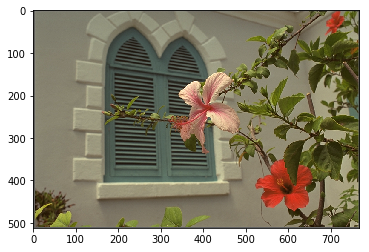

In [15]:
img = cv2.imread("./kodim07.png")
print(img.shape)
Z = img.reshape((-1,3))
Z = np.float32(Z)
print(Z.shape) #each entry in Z is the RGB value of a pixel

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
clustered, means = kmeans(Z,12) 
new_img = np.array([means[x] for x in clustered])
final = new_img.reshape((img.shape))
cv2.imwrite("./kodims07_12means.png",final)

104.18144733672536
40.63151276672504
29.92023826186552
29.331461367482053
25.05236072220541
22.338631373002066
18.669487579377847
12.788816002643541


True

In [20]:
reduced = shrink(clustered)
reduction = clustered.shape[0]/(len(reduced)*2)
print(reduction) #factor by which we can reduce cluster indices

3.0314542987541633


In [22]:
original = img.shape[0]*img.shape[1]*img.shape[2]
final = clustered.shape[0] + len(means)
final_reduced = (len(reduced)*2) + len(means)
cr = original/final
cr_reduced = original/final_reduced
print(cr) #compression ratio
print(cr_reduced) #compression ratio with reduction

2.9999084500595075
9.093521630538682


The compression ratio is the number of times more space it takes to store the original image than the compressed image. A compression ratio of 2, for example, means the compressed image should take about half the space to store. A higher compression ratio and smaller file size is usually accompanied by a loss in image quality.